In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging

In [2]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
from graphlearn.graphlearn import GraphLearnSampler
from eden.util import fit,estimate
from eden.graph import Vectorizer
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

In [3]:
def fit_sample(graphs):
    graphs, graphs_ = tee(graphs)
    sampler=GraphLearnSampler(radius_list=[0,1],thickness_list=[1],
                              min_cip_count=2, min_interface_count=2,
                              vectorizer=Vectorizer(5))
    
    sampler.fit(graphs, nu=0.3, n_jobs=-1)

    logger.info('graph grammar stats:')
    interface_counts, core_counts, cip_counts = sampler.grammar().size()
    logger.info('#interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (interface_counts, core_counts, cip_counts))
    graphs = sampler.sample(graphs_,
                            n_steps=5, n_samples=4,
                            target_orig_cip=True,
                            probabilistic_core_choice=False,
                            score_core_choice= True,
                            max_core_size_diff=0,
                            improving_threshold=0.3, accept_static_penalty=0,
                            generator_mode=True,
                            n_jobs=-1,burnin=1,select_cip_max_tries=200,keep_duplicates=True)
    return graphs

In [4]:
def fit_and_evaluate(pos_original, neg_original,
                     pos_sampled, neg_sampled,
                     pos_test, neg_test):
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = tee(pos_original)
    neg_orig,neg_orig_ = tee(neg_original)
    
    pos_sampled, pos_sampled_ = tee(pos_sampled)
    neg_sampled, neg_sampled_ = tee(neg_sampled)
    
    pos_augmented = chain(pos_orig_,pos_sampled_)
    neg_augmented = chain(neg_orig_,neg_sampled_)

    predictive_performances = []
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),
                                     ('sample',pos_sampled,neg_sampled),
                                     ('original+sample',pos_augmented, neg_augmented)]:
        pos_train,pos_train_ = tee(pos_train)
        neg_train,neg_train_ = tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)

        logger.info( "-"*80)
        logger.info('working on %s'%(desc))
        logger.info('training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size))

        if pos_size == 0 or neg_size == 0:
            logger.info('WARNING: empty dataset')
            predictive_performances.append(0)            
        else:
            start=time()
            pos_test,pos_test_ = tee(pos_test)
            neg_test,neg_test_ = tee(neg_test)
            local_estimator = fit(pos_train, neg_train, Vectorizer(4), n_jobs=-1, n_iter_search=1)
            apr, roc = estimate(pos_test_, neg_test_, local_estimator, Vectorizer(4))
            predictive_performances.append(roc)
            logger.info( 'elapsed: %.1f sec'%(time()-start))
    return predictive_performances

In [5]:
def evaluate(pos_fname, neg_fname, size=None, percentages=None, n_repetitions=None, train_test_split=None):
    # initializing 
    graphs_pos = get_graphs(pos_fname, size=size)
    graphs_neg = get_graphs(neg_fname, size=size)

    # train/test split
    from eden.util import random_bipartition_iter
    pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,train_test_split)
    neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,train_test_split)


    original_repetitions = []
    original_sample_repetitions = []
    sample_repetitions = []

    for percentage in percentages:
        originals = []
        originals_samples = []
        samples = []
        for repetition in range(n_repetitions):
            random.seed(int(313379*percentage+repetition))
            pos_train_global,pos_train_global_ = tee(pos_train_global)
            neg_train_global,neg_train_global_ = tee(neg_train_global)
            pos_test_global,pos_test_global_ = tee(pos_test_global)
            neg_test_global,neg_test_global_ = tee(neg_test_global)

            # use shuffled list to create test and sample set
            pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
            pos,pos_ = tee(pos)
            neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
            neg,neg_ = tee(neg)

            #sample independently from the 2 classes
            logger.info('Positive')
            sampled_pos = fit_sample(pos_)
            logger.info('Negative')
            sampled_neg = fit_sample(neg_)

            #evaluate the predictive performance on held out test set
            start=time()
            logger.info( "="*80)
            logger.info( 'repetition: %d/%d'%(repetition+1, n_repetitions))
            logger.info( "training percentage:"+str(percentage))
            perf_orig,\
            perf_samp,\
            perf_orig_samp = fit_and_evaluate(pos,neg,
                                              sampled_pos,sampled_neg,
                                              pos_test_global_,neg_test_global_)
            logger.info( 'Time elapsed: %.1f sec'%((time()-start)))
            originals.append(perf_orig)
            originals_samples.append(perf_orig_samp)
            samples.append(perf_samp)

        original_repetitions.append(originals)
        original_sample_repetitions.append(originals_samples)
        sample_repetitions.append(samples)
    
    return original_repetitions, original_sample_repetitions, sample_repetitions

In [6]:
def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions):
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    ws = 0.02
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original+sample')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='original')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample')

    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.title(dataset+'\n',fontsize=17)
    plt.legend(loc='lower right',fontsize=16)
    plt.ylabel('ROC AUC',fontsize=16)
    plt.xlabel('Dataset size (fraction)',fontsize=16)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

Working with dataset: HL_60_TB_t
Positive
graph grammar stats:
#interfaces: 23   #cores: 26   #core-interface-pairs: 82
Negative
graph grammar stats:
#interfaces: 16   #cores: 21   #core-interface-pairs: 50
repetition: 1/2
training percentage:0.4
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 16 #neg: 16
Test set
Instances: 80 ; Features: 1048577 with an avg of 335 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.54      0.33      0.41        40
          1       0.52      0.72      0.60        40

avg / total       0.53      0.53      0.51        80

APR: 0.524
ROC: 0.517
Cross-validated estimate
            accuracy: 0.625 +- 0.143
           precision: 0.658 +- 0.167
              recall: 0.625 +- 0.079
                  f1: 0.633 +- 0.106
   average_precision: 0.7

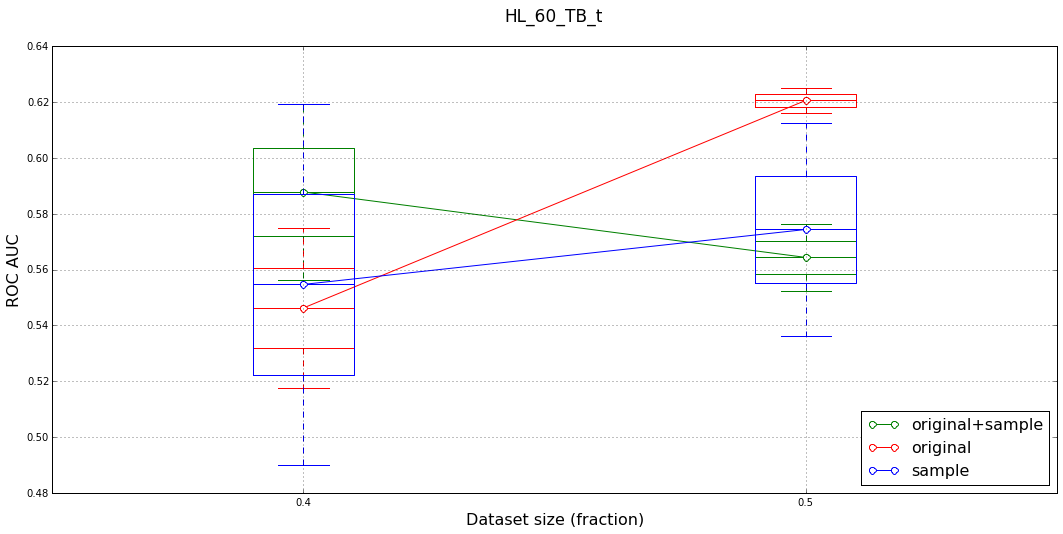

In [28]:
#%%time
#experiment

dataset_names = !cat NCI60/names

dataset=dataset_names[1]
logger=logging.getLogger()
configure_logging(logger,verbosity=1, filename='%s_predictive_performance_of_samples.log'%dataset)
logger.info( 'Working with dataset: %s' % dataset )

pos_dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
neg_dataset_fname = 'NCI60/' + dataset + '_orig_neg.gspan'
#pos_dataset_fname = 'bursi.pos.gspan'
#neg_dataset_fname = 'bursi.neg.gspan'

percentages=[.05,.2,.4,.6,.8,.95]
percentages=[.4,.5]


original_repetitions,\
original_sample_repetitions,\
sample_repetitions = evaluate(pos_dataset_fname,
                              neg_dataset_fname,
                              size=80,
                              percentages=percentages,
                              n_repetitions=2,
                              train_test_split=0.5)

plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions)


In [29]:
def save_results(dataset,percentages, original_repetitions,original_sample_repetitions,sample_repetitions):
    result_fname='%s.data'%dataset
    with open(result_fname,'w') as f:
        f.write('dataset_size:\n')
        for perc in percentages:
            f.write('%s '% perc)
        f.write('\n')
        f.write('AUC scores:\n')
        for repetitions in original_repetitions,original_sample_repetitions,sample_repetitions:
            f.write('%s\n' % len(repetitions))
            for repetition in repetitions:
                for auc in repetition:
                    f.write('%s ' % auc)
                f.write('\n')
    
def load_results(dataset):
    percentages = []
    original_repetitions = []
    original_sample_repetitions = []
    sample_repetitions = []
    result_fname='%s.data'%dataset
    with open(result_fname) as f:
        comment = next(f)
        print comment
        size = int(next(f))
        print size
    return percentages, original_repetitions,original_sample_repetitions,sample_repetitions

In [30]:
save_results(dataset,percentages, original_repetitions,original_sample_repetitions,sample_repetitions)
!cat $result_fname
percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(dataset)

dataset_size:
0.4 0.5 
AUC scores:
2
0.5175 0.575 
0.625 0.61625 
2
0.619375 0.55625 
0.57625 0.5525 
2
0.619375 0.49 
0.53625 0.6125 
dataset_size:



ValueError: invalid literal for int() with base 10: '0.4 0.5 \n'

In [ ]:
%%time
#experiment

dataset_names = !cat NCI60/names

for dataset in dataset_names:
    configure_logging(logging.getLogger(),verbosity=1, filename='%s_predictive_performance_of_samples.log'%dataset)
    logger.info( 'Working with dataset: %s' % dataset )
    
    pos_dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
    neg_dataset_fname = 'NCI60/' + dataset + '_orig_neg.gspan'
    #pos_dataset_fname = 'bursi.pos.gspan'
    #neg_dataset_fname = 'bursi.neg.gspan'

    percentages=[.05,.2,.4,.6,.8,.95]
    percentages=[.5]


    original_repetitions,\
    original_sample_repetitions,\
    sample_repetitions = evaluate(pos_dataset_fname,
                                  neg_dataset_fname,
                                  size=80,
                                  percentages=percentages,
                                  n_repetitions=2,
                                  train_test_split=0.5)
    
    plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions)


.

**TO DO:**

- save results as text vector files
- do the plots from the reloaded result files